In [265]:
import os
import gc
import sys
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format

cuda:1


> ### Train data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [10]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [84]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [85]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [86]:
FAULT_START_TRAINVAL = 20
FAULT_START_TEST = 160

In [87]:
BATCH_SIZE = 64
NUM_CLASSES = 21

> ### Models

In [88]:
class UniRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        x_rnn_out, _ = self.rnn(x_packed)
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        x = self.head(x_last_hiddens)
        
        return x

In [89]:
class AttentionModel(torch.nn.Module):
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL):
        super().__init__()
        
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        rnn_cell = getattr(nn, RNN_TYPE)

        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size, 
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        dropout=0.4,
                        batch_first=True
                )
        
        self.head = nn.Sequential(
#                         nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.output_size),
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
        
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type, 
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional
        }
    

    def attention(self, lstm_output, last_hidden):
        
        attn_weights = torch.bmm(lstm_output, last_hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state
    
    def forward(self, x, x_length):

        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        attention_out = self.attention(x_unpacked, x_last_hiddens)
        x = self.head(attention_out)

        return x

In [90]:
class TransformerModel(torch.nn.Module):
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DROPOUT):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.dropout = DROPOUT
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
                        d_model=self.input_size, 
                        nhead=4, 
                        dim_feedforward=self.hidden_size, 
                        dropout=self.dropout, 
                        activation='relu'
                )
        
        
        self.transformer_encoder = nn.TransformerEncoder(
                        encoder_layer=transformer_encoder_layer, 
                        num_layers=self.num_layers, 
                        norm=None
                )
        
        self.weighted_mean = nn.Conv1d(
                        in_channels=self.input_size, 
                        out_channels=self.input_size, 
                        kernel_size=250, 
                        groups=self.input_size)
    
        self.head = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=52, out_features=self.output_size),
#                         nn.Linear(in_features=52, out_features=self.linear_size),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.4),
#                         nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
    
    def get_params(self):
        
        return {
                "HIDDEN_SIZE": self.hidden_size,
                "NUM_LAYERS": self.num_layers,
                "INPUT_SIZE": self.input_size,
                "LINEAR_SIZE": self.linear_size,
                "OUTPUT_SIZE": self.output_size,
                "DROPOUT": self.dropout
            }    
    
    
    def forward(self, x, x_length=None):
        """
        src: (S, N, E) = (sequence_length, batch_size, n_features)
        src_key_padding_mask: (N, S) = (batch_size, sequence_length)
        """
    
        x_mask = torch.zeros(x.size(0), x.size(1), dtype=bool, device=x.device)
        
        for i in range(len(x)):
            x_mask[i, x_length[i]:] = True

        x = self.transformer_encoder(src=x.transpose(0, 1), src_key_padding_mask=x_mask)
        x = x.permute(1, 2, 0)
        x = self.weighted_mean(x)
        x = x.squeeze(-1)
        x = self.head(x)

        return x

In [91]:
class MultiRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
#         print("x", x.size())
        x, _ = self.rnn(x)
#         print("x", x.size())
        x = self.head(x)
#         print("x", x.size())
        
        return x

> ### Loading best model

In [92]:
! ls final_saved_models/

attention  multi_rnn  rnn  transformer


In [93]:
! ls final_saved_models/attention/

GRU_22May-14-28.pth  LSTM_22May-20-05.pth


In [94]:
! ls final_saved_models/multi_rnn/

GRU_22May-14-35.pth  LSTM_22May-16-20.pth


In [95]:
! ls final_saved_models/rnn/

GRU_22May-14-24.pth  LSTM_22May-20-05.pth


In [96]:
! ls final_saved_models/transformer

TRANSFORMER_22May-14-31.pth


In [97]:
# checkpoint_att_lstm = torch.load(f"final_saved_models/attention/LSTM_22May-20-05.pth")
# checkpoint_att_gru = torch.load(f"final_saved_models/attention/GRU_22May-14-28.pth")

# checkpoint_multi_gru = torch.load(f"final_saved_models/multi_rnn/GRU_22May-14-35.pth")
# checkpoint_multi_lstm = torch.load(f"final_saved_models/multi_rnn/LSTM_22May-16-20.pth")

# checkpoint_rnn_lstm = torch.load(f"final_saved_models/rnn/LSTM_22May-20-05.pth")
# checkpoint_rnn_gru = torch.load(f"final_saved_models/rnn/GRU_22May-14-24.pth")


# checkpoint_trans = torch.load(f"final_saved_models/transformer/TRANSFORMER_22May-14-31.pth")

In [98]:
path_att_lstm = f"final_saved_models/attention/LSTM_22May-20-05.pth"
path_att_gru = f"final_saved_models/attention/GRU_22May-14-28.pth"

path_multi_gru = f"final_saved_models/multi_rnn/GRU_22May-14-35.pth"
path_multi_lstm = f"final_saved_models/multi_rnn/LSTM_22May-16-20.pth"

path_rnn_lstm = f"final_saved_models/rnn/LSTM_22May-20-05.pth"
path_rnn_gru = f"final_saved_models/rnn/GRU_22May-14-24.pth"


path_trans = f"final_saved_models/transformer/TRANSFORMER_22May-14-31.pth"

In [99]:
def get_model(path):
    
    checkpoint = torch.load(path)
    model = getattr(sys.modules[__name__], checkpoint['model'])(**checkpoint['params'])
    model.load_state_dict(checkpoint['state_dict'])

    for parameter in model.parameters():
            parameter.requires_grad = False

    model.eval()
    model = model.to(device)
    
    return model

In [100]:
get_model(f"final_saved_models/attention/LSTM_22May-20-05.pth")

AttentionModel(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [101]:
model_att_lstm = get_model(f"final_saved_models/attention/LSTM_22May-20-05.pth")
model_att_gru = get_model(f"final_saved_models/attention/GRU_22May-14-28.pth")

model_multi_gru = get_model(f"final_saved_models/multi_rnn/GRU_22May-14-35.pth")
model_multi_lstm = get_model(f"final_saved_models/multi_rnn/LSTM_22May-16-20.pth")

model_rnn_lstm = get_model(f"final_saved_models/rnn/LSTM_22May-20-05.pth")
model_rnn_gru = get_model(f"final_saved_models/rnn/GRU_22May-14-24.pth")

model_trans = get_model(f"final_saved_models/transformer/TRANSFORMER_22May-14-31.pth")

> ### Metrics and graphs

In [102]:
def get_metrics(y_true, y_pred):
    
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs
    https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

    Parameters
    ----------
    y_true : 
        type: np.array 
        shape : (number of simulation runs)
        description: true classes for simulation runs
    
    y_pred : np.array
    
        type: np.array 
        shape : (number of simulation runs)
        description: predicted classes for simulation runs
        
    Returns
    -------
    TPR : 
        type: list of floats
        shape: (number of classes)
        description: True Positive Rate per class
    FPR : 
        type: list of floats
        shape: (number of classes)
        description: False Positive Rate per class
    ACCURACY : 
        type: list of floats
        shape: (number of classes)
        description: Accuracy "one vs all" per class
    """
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

In [231]:
def get_first_true_idx(arr):
    idx = np.where(arr == True)[0]
    
    if len(idx) == 0:
        return -999
    else:
        return idx.min() + 1

def get_detection_delay(y_true, y_pred) -> dict():
    """
    Calculates detection delay for every simulation run

    Parameters
    ----------
    y_true : 
        type : np.array 
        shape : (number of simulation runs)
        description : true classes for simulation runs
    
    y_pred : np.array 
        type : np.array 
        shape : (number of simulation runs, simulation runs' lengths)
        description: predicted classes for every sample for every simulation runs
        
    Returns
    -------
    detection_delay :
        type : dict
        keys : classes from 0 to 20
        description : dict of detection delays for every class, nan means true class wasn't predicted
    
    Commentary:
        If you want to get avarage detection delays per class, you need to calulate avg of detection_delay[key]
        for every key 
        
    """
    
    detection_delay = defaultdict(list)
    
    correct = y_pred == y_true[..., np.newaxis]
    first_true_idxs = np.apply_along_axis(func1d=get_first_true_idx, arr=correct, axis=1)
    
    first_true_idxs = first_true_idxs.astype(float)
    first_true_idxs[first_true_idxs == -999] = np.NaN

    for i, (cls, idx) in enumerate(zip(y_true, first_true_idxs)):
        detection_delay[cls].append(idx)
    return detection_delay

> ### Test inference

In [104]:
gc.collect()

8

In [82]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [105]:
raw_test[features] = scaler.transform(raw_test[features])

In [106]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [107]:
raw_test.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
index,,,,,,,,,,,,,,,,,,,,,
0.0,0,1.0,1,-0.061905,0.201545,-0.366697,0.396960,0.672885,0.349442,-0.223455,...,0.036876,-0.280430,-0.477229,-0.047406,0.017518,0.678059,0.641891,-0.185190,0.014966,-0.693145
0.0,0,1.0,2,-0.057595,-0.504438,0.575905,0.124438,0.421859,0.709238,-0.228836,...,-0.201046,-0.283523,-0.372900,-0.042150,0.002242,-0.482106,-0.595256,-0.173439,-0.142419,-0.548871
0.0,0,1.0,3,-0.084550,-0.483398,0.012553,-0.222560,0.110240,-0.271443,-0.251702,...,-0.059070,-0.263817,-0.348612,-0.062236,0.011582,1.286104,-0.800952,-0.174777,-0.062251,0.333051
0.0,0,1.0,4,-0.063137,-0.829377,0.121173,-0.098154,0.421859,-0.105874,-0.246322,...,-0.086261,-0.279133,-0.173902,-0.082698,0.016885,0.675348,0.681334,-0.177046,-0.119325,-0.335875
0.0,0,1.0,5,-0.295060,-0.186512,0.597077,-0.170677,-0.002289,0.123376,-0.195209,...,-0.193666,-0.417724,-0.176248,-0.042244,-0.176629,0.075099,-0.747937,-0.171810,-0.087889,-0.022812


In [108]:
class DataTEST_uni(Dataset):

    def __init__(self, X, seq_length):
    
        self.X = X
        self.seq_length = seq_length
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[FAULT_START_TEST : (FAULT_START_TEST+self.seq_length), :]
        target = self.X.loc[idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target
    

class DataTEST_multi(Dataset):

    def __init__(self, X):
    
        self.X = X
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[FAULT_START_TEST:, :]
        target = self.X.loc[idx]['faultNumber'].values[FAULT_START_TEST:]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [109]:
def inference_multi(model):
    
    test_ds = DataTEST_multi(raw_test)
    test_dl = DataLoader(test_ds, batch_size=512)

    metrics = dict()
    y_ans_test_all = []

    y_ans_test, y_true_test = [], []

    start = time.time()

    model.eval()
    for (X_batch_test, y_batch_test) in tqdm(test_dl):

        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        y_pred_test = model(X_batch_test, None)

        y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]

        y_ans_test.append(y_pred_class.cpu().numpy())
        y_true_test.append(y_batch_test.cpu().numpy())

        end = time.time()

    print(f"seq_length time: {end - start}")  
    
    y_ans_test_all = np.concatenate(y_ans_test, axis=0)
    y_true_test_all = np.concatenate(y_true_test, axis=0)
    
    return y_ans_test_all, y_true_test_all

In [115]:
def inference_uni(model):  
    
    SEQ_LEN = 800
    
    y_ans_test_all, y_true_test_all = [], []

    test_ds = DataTEST_uni(raw_test, seq_length=SEQ_LEN)
    test_dl = DataLoader(test_ds, batch_size=512)

    model_rnn_gru.eval()

    for (X_batch_test, y_batch_test) in tqdm(test_dl):

        y_ans_test, y_true_test = [], []
        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        for i in range(2, SEQ_LEN):

            X_batch_lengths_test = torch.tensor([i]*len(X_batch_test)).to(device)            
            y_pred_test = model_rnn_gru(X_batch_test[:, :i, :], X_batch_lengths_test)

            y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
            y_pred_class = y_pred_prob.max(dim=-1)[1]

            y_ans_test.append(y_pred_class.tolist())
            y_true_test.append(y_batch_test.tolist())

            end = time.time()

        y_ans_test_all.append(np.array(y_ans_test).T)
        y_true_test_all.append(np.array(y_true_test).T)

    y_ans_test_all = np.concatenate(y_ans_test_all)   
    y_true_test_all = np.concatenate(y_true_test_all)   

    return y_ans_test_all, y_true_test_all

In [116]:
! ls final_preds_saved/

att_gru  att_lstm  multi_gru  multi_lstm  rnn_gru  rnn_lstm  trans


In [266]:
# y_pred_classes, y_true_classes = inference_multi(model_multi_gru)

# np.savetxt("final_preds_saved/multi_gru/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/multi_gru/y_true_classes.csv", y_true_classes, delimiter=",")  

In [267]:
# y_pred_classes, y_true_classes = inference_multi(model_multi_lstm)

# np.savetxt("final_preds_saved/multi_lstm/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/multi_lstm/y_true_classes.csv", y_true_classes, delimiter=",")  

In [268]:
# y_pred_classes, y_true_classes = inference_uni(model_rnn_gru)

# np.savetxt("final_preds_saved/rnn_gru/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/rnn_gru/y_true_classes.csv", y_true_classes, delimiter=",")  

In [269]:
# y_pred_classes, y_true_classes = inference_uni(model_rnn_lstm)

# np.savetxt("final_preds_saved/rnn_lstm/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/rnn_lstm/y_true_classes.csv", y_true_classes, delimiter=",")  

In [270]:
# y_pred_classes, y_true_classes = inference_uni(model_att_lstm)

# np.savetxt("final_preds_saved/att_lstm/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/att_lstm/y_true_classes.csv", y_true_classes, delimiter=",")  

In [271]:
# y_pred_classes, y_true_classes = inference_uni(model_att_gru)

# np.savetxt("final_preds_saved/att_gru/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/att_gru/y_true_classes.csv", y_true_classes, delimiter=",")  

In [272]:
# y_pred_classes, y_true_classes = inference_uni(model_trans)

# np.savetxt("final_preds_saved/trans/y_pred_classes.csv", y_pred_classes, delimiter=",")   
# np.savetxt("final_preds_saved/trans/y_true_classes.csv", y_true_classes, delimiter=",")  

> ### Visualization

In [122]:
models = {}

In [123]:
models['multi_gru'] = {}
models['multi_lstm'] = {}

models['rnn_gru'] = {}
models['rnn_lstm'] = {}

models['attention_gru'] = {}
models['attention_lstm'] = {}

models['transformer'] = {}

In [124]:
models['multi_gru']['pred'] = "final_preds_saved/multi_gru/y_pred_classes.csv"
models['multi_gru']['true'] = "final_preds_saved/multi_gru/y_true_classes.csv"

models['multi_lstm']['pred'] = "final_preds_saved/multi_lstm/y_pred_classes.csv"
models['multi_lstm']['true'] = "final_preds_saved/multi_lstm/y_true_classes.csv"

models['rnn_gru']['pred'] = "final_preds_saved/rnn_gru/y_pred_classes.csv"
models['rnn_gru']['true'] = "final_preds_saved/rnn_gru/y_true_classes.csv"

models['rnn_lstm']['pred'] = "final_preds_saved/rnn_lstm/y_pred_classes.csv"
models['rnn_lstm']['true'] = "final_preds_saved/rnn_lstm/y_true_classes.csv"

models['attention_gru']['pred'] = "final_preds_saved/att_gru/y_pred_classes.csv"
models['attention_gru']['true'] = "final_preds_saved/att_gru/y_true_classes.csv"

models['attention_lstm']['pred'] = "final_preds_saved/att_lstm/y_pred_classes.csv"
models['attention_lstm']['true'] = "final_preds_saved/att_lstm/y_true_classes.csv"

models['transformer']['pred'] = "final_preds_saved/trans/y_pred_classes.csv"
models['transformer']['true'] = "final_preds_saved/trans/y_true_classes.csv"

In [240]:
STEPS = [5, 50, 100, -1]

for model in tqdm(models.keys()):
    
    y_true_classes = np.genfromtxt(models[model]['true'], delimiter=',')
    y_pred_classes = np.genfromtxt(models[model]['pred'], delimiter=',')
    
    detection_delay = get_detection_delay(y_true=y_true_classes[:, -1], y_pred=y_pred_classes)
    
    detection_delay_mean = {}
    for (k, v) in detection_delay.items():
        detection_delay_mean[k] = np.nanmean(v)
        
    models[model]['detection_delay'] = detection_delay_mean
    
    for step in STEPS:
        
        TPR, FPR, ACCURACY = get_metrics(y_true=y_true_classes[:, -1], y_pred=y_pred_classes[:, step])
        
        models[model][step] = {}
        
        models[model][step]['TPR'] = TPR
        models[model][step]['FPR'] = FPR
        models[model][step]['ACCURACY'] = ACCURACY

In [243]:
models['multi_gru']['marker_style'] = '*'
models['multi_gru']['marker_color'] = 'olivedrab'
models['multi_gru']['label'] = 'gru type: 2'

models['multi_lstm']['marker_style'] = '*'
models['multi_lstm']['marker_color'] = 'yellowgreen'
models['multi_lstm']['label'] = 'lstm type: 2'

models['rnn_gru']['marker_style'] = 'X'
models['rnn_gru']['marker_color'] = 'gold'
models['rnn_gru']['label'] = 'gru type: 1'

models['rnn_lstm']['marker_style'] = 'X'
models['rnn_lstm']['marker_color'] = 'khaki'
models['rnn_lstm']['label'] = 'lstm type: 1'

models['attention_gru']['marker_style'] = 'x'
models['attention_gru']['marker_color'] = 'skyblue'
models['attention_gru']['label'] = 'gru + att type: 1'

models['attention_lstm'] ['marker_style'] = 'x'
models['attention_lstm'] ['marker_color'] = 'steelblue'
models['attention_lstm']['label'] = 'lstm + att type: 1'

models['transformer']['marker_style'] = '.'
models['transformer']['marker_color'] = 'pink'
models['transformer']['label'] = 'transformer'

In [245]:
def get_results(step=-1):
    
    classes = np.arange(21)
    xticks = ["fault_" + str(c) if c > 0 else "normal" for c in classes]
    cols_order = [
                    'gru type: 1', 'lstm type: 1', 'gru + att type: 1', 'lstm + att type: 1', 'transformer', 
                    'gru type: 2', 'lstm type: 2'
            ]

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 25))

    ax[0].title.set_text(f'TPR (true positive rate) per class')
    ax[0].set_xticks(classes)
    ax[0].set_xticklabels(xticks, rotation=30)
    ax[0].set_xlabel('class')
    ax[0].set_ylabel(f'TPR')
    ax[0].set_ylim(0.7, 1.05)


    ax[1].title.set_text(f'FPR (false positive rate) per class')
    ax[1].set_xticks(classes)
    ax[1].set_xticklabels(xticks, rotation=30)
    ax[1].set_xlabel('class')
    ax[1].set_ylabel(f'FPR')
    ax[1].set_ylim(0, 0.015)


    ax[2].title.set_text(f'ACCURACY per class')
    ax[2].set_xticks(classes)
    ax[2].set_xticklabels(xticks, rotation=30)
    ax[2].set_xlabel('class')
    ax[2].set_ylabel(f'ACCURACY')
    ax[2].set_ylim(0.8, 1.05)


    ax[3].title.set_text(f'Average detection delay per class')
    ax[3].set_xticks(classes)
    ax[3].set_xticklabels(xticks, rotation=30)
    ax[3].set_xlabel('class')
    ax[3].set_ylabel(f'Time steps')

    tpr_df = pd.DataFrame()
    fpr_df = pd.DataFrame()
    acc_df = pd.DataFrame()
    dd_df = pd.DataFrame()

    for model in models.keys():

        dd = list(models[model]['detection_delay'].values())

        ax[0].plot(models[model][step]['TPR'], 
                   f"-{models[model]['marker_style']}",
                   color=models[model]['marker_color'], 
                   markersize=8,
                   label=models[model]['label'])

        ax[1].plot(models[model][step]['FPR'], 
                   f"-{models[model]['marker_style']}",
                   color=models[model]['marker_color'],
                   markersize=8,
                   label=models[model]['label'])

        ax[2].plot(models[model][step]['ACCURACY'], 
                   f"-{models[model]['marker_style']}", 
                   color=models[model]['marker_color'],
                   markersize=8,
                   label=models[model]['label'])

        ax[3].plot(dd, 
                   f"-{models[model]['marker_style']}",
                   color=models[model]['marker_color'], 
                   markersize=8,
                   label=models[model]['label'])

        tpr_df[models[model]['label']] = models[model][step]['TPR']
        fpr_df[models[model]['label']] = models[model][step]['FPR']
        acc_df[models[model]['label']] = models[model][step]['ACCURACY']
        dd_df[models[model]['label']] = dd

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

    plt.tight_layout()
    plt.show()

    fig.savefig(f"results_{step}.png")

    tpr_df.index = xticks
    fpr_df.index = xticks
    acc_df.index = xticks
    dd_df.index = xticks
    
    tpr_df = tpr_df[cols_order]
    fpr_df = fpr_df[cols_order]
    acc_df = acc_df[cols_order]
    dd_df = dd_df[cols_order]
    
    return tpr_df, fpr_df, acc_df, dd_df

In [246]:
STEPS

[5, 50, 100, -1]

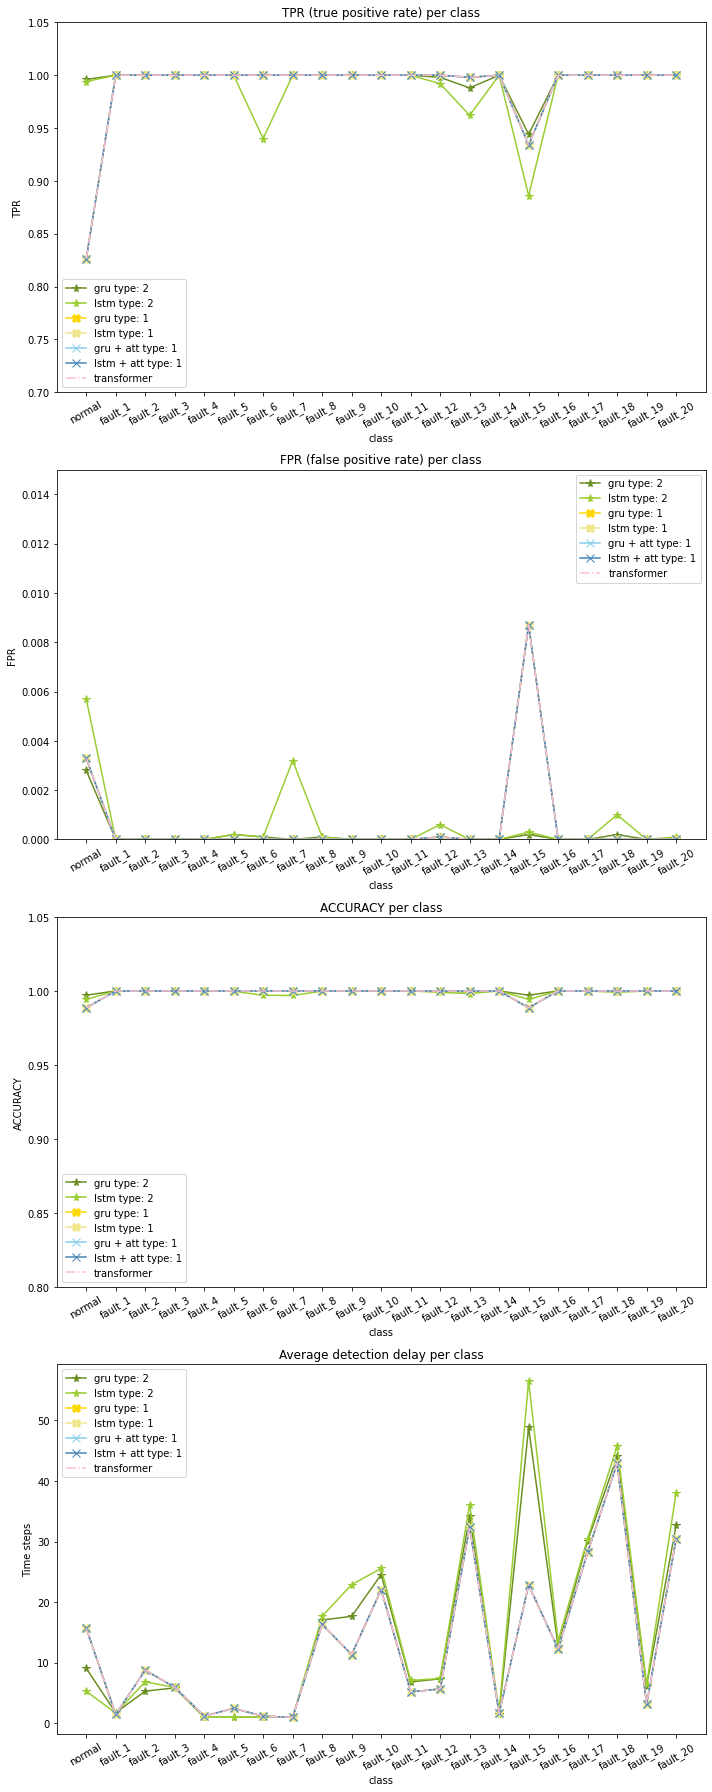

In [247]:
tpr_df_last, fpr_df_last, acc_df_last, dd_df_last = get_results(step=-1)

In [260]:
dd_df_last.to_csv("dd_df_last.csv", float_format='%.2f')
tpr_df_last.to_csv("tpr_df_last.csv", float_format='%.2f')
fpr_df_last.to_csv("fpr_df_last.csv", float_format='%.2f')
acc_df_last.to_csv("acc_df_last.csv", float_format='%.2f')

> ### Model's summary

In [166]:
model_att_lstm
model_att_gru
model_multi_gru
model_multi_lstm
model_rnn_lstm
model_rnn_gru
model_trans

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=52, out_features=52, bias=True)
        )
        (linear1): Linear(in_features=52, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=128, out_features=52, bias=True)
        (norm1): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=52, out_features=52, bias=True)
        )
        (linear1): Linear(in_features=52, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_fea

In [185]:
def summary(model, idxs):

    for i, item in enumerate(model.named_modules()):
        print(i, item[1])
        
    print("------------------------------------------------------------------------------------\n")
    
    for i, item in enumerate(model.named_modules()):
        if i in idxs:
            print(item[1])

In [191]:
summary(model_multi_gru, [1, 3, 4, 5, 6])

0 MultiRNN(
  (rnn): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4)
2 Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=128, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4)
Linear(in_features=128, out_features=64, bias=True)
ReLU()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out_features=21, bias=True)


In [192]:
summary(model_multi_lstm, [1, 3, 4, 5, 6])

0 MultiRNN(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4)
2 Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=128, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4)
Linear(in_features=128, out_features=64, bias=True)
ReLU()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out_features=21, bias=True)


In [190]:
summary(model_rnn_gru, [0,1,2,3,4,5])

0 UniRNN(
  (rnn): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
2 Sequential(
  (0): Linear(in_features=256, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=256, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

UniRNN(
  (rnn): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2)

In [193]:
summary(model_rnn_lstm, [0,1,2,3,4,5])

0 UniRNN(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
2 Sequential(
  (0): Linear(in_features=256, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=256, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

UniRNN(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    

In [195]:
summary(model_att_gru, [1,3,4,5,6])

0 AttentionModel(
  (rnn): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
2 Sequential(
  (0): Linear(in_features=256, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=256, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

GRU(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
Linear(in_features=256, out_features=64, bias=True)
ReLU()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out

In [196]:
summary(model_att_lstm, [1,3,4,5,6])

0 AttentionModel(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)
1 LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
2 Sequential(
  (0): Linear(in_features=256, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=21, bias=True)
)
3 Linear(in_features=256, out_features=64, bias=True)
4 ReLU()
5 Dropout(p=0.4, inplace=False)
6 Linear(in_features=64, out_features=21, bias=True)
------------------------------------------------------------------------------------

LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
Linear(in_features=256, out_features=64, bias=True)
ReLU()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, 

In [197]:
summary(model_trans, [1,3,4,5,6])

0 TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=52, out_features=52, bias=True)
        )
        (linear1): Linear(in_features=52, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=128, out_features=52, bias=True)
        (norm1): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=52, out_features=52, bias=True)
        )
        (linear1): Linear(in_features=52, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_f